# PyDMD

### Tutorial 3: DMD multirresolução: diferentes escalas de tempo

Neste tutorial mostraremos as possibilidades de decomposição de modos dinâmicos multiresolução (mrDMD) em relação ao DMD clássico. Seguimos uma postagem maravilhosa no blog escrita por Robert Taylor [disponível aqui](http://www.pyrunner.com/weblog/2016/08/05/mrdmd-python/). Não usamos sua implementação do mrDMD, mas apenas os dados de amostra e a estrutura do tutorial. Você pode encontrar uma referência matemática para o mrDMD por Kutz et al. [aqui](http://epubs.siam.org/doi/pdf/10.1137/15M1023543).
Para as configurações avançadas da classe base DMD, consulte [este tutorial](https://github.com/mathLab/PyDMD/blob/master/tutorials/tutorial-2-adv-dmd.ipynb).

Primeiro de tudo, apenas importamos as classes MrDMD e DMD do pacote pydmd, configuramos matplotlib para o notebook e importamos numpy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pydmd import MrDMD, DMD
from pydmd.plotter import plot_eigs_mrdmd
import numpy as np

O código abaixo gera um conjunto de dados de exemplo espaço-temporal. Os dados podem ser considerados como 80 locais ou sinais (o eixo x) sendo amostrados 1.600 vezes a uma taxa constante no tempo (o eixo t). Ele contém muitos recursos em escalas de tempo variadas, como senos e cossenos oscilantes, eventos únicos e ruído aleatório.

In [2]:
def create_sample_data():
    # Crea una lista con 80 datos en "X"
    x = np.linspace(-10, 10, 80)
    # Crea una lista con 80 datos en "t"
    t = np.linspace(0, 20, 1600)
    
    # Crea una malla de las dos variables 
    Xm, Tm = np.meshgrid(x, t)

    # Sinais de entrada 
    D = np.exp(-np.power(Xm / 2, 2)) * np.exp(0.8j * Tm)
    D += np.sin(0.9 * Xm) * np.exp(1j * Tm)
    D += np.cos(1.1 * Xm) * np.exp(2j * Tm)
    D += 0.6 * np.sin(1.2 * Xm) * np.exp(3j * Tm)
    D += 0.6 * np.cos(1.3 * Xm) * np.exp(4j * Tm)
    D += 0.2 * np.sin(2.0 * Xm) * np.exp(6j * Tm)
    D += 0.2 * np.cos(2.1 * Xm) * np.exp(8j * Tm)
    D += 0.1 * np.sin(5.7 * Xm) * np.exp(10j * Tm)
    D += 0.1 * np.cos(5.9 * Xm) * np.exp(12j * Tm)
    D += 0.1 * np.random.randn(*Xm.shape)
    D += 0.03 * np.random.randn(*Xm.shape)
    D += (5* np.exp(-np.power((Xm + 5) / 5, 2))* np.exp(-np.power((Tm - 5) / 5, 2)))
    D[:800, 40:] += 2
    D[200:600, 50:70] -= 3
    D[800:, :40] -= 2
    D[1000:1400, 10:30] += 3
    D[1000:1080, 50:70] += 2
    D[1160:1240, 50:70] += 2
    D[1320:1400, 50:70] += 2
    
    return D.T

Aqui temos uma função auxiliar que usaremos para plotar os dados.

In [3]:
def make_plot(X, x=None, y=None, figsize=(12, 8), title=""):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    # Converte os dados X para a parte real, removendo qualquer parte imaginária dos números complexos.
    X = np.real(X)
    # Cria um gráfico de cor para os dados X, onde x e y são as coordenadas espaciais e temporais, respectivamente.
    CS = plt.pcolor(x, y, X)
    # Adiciona uma barra de cor ao gráfico para indicar a correspondência entre as cores e os valores dos dados
    cbar = plt.colorbar(CS)
    plt.xlabel("Space-1D")
    plt.ylabel("Time")
    plt.show()

Vamos começar criando o conjunto de dados e plotando os dados para termos uma primeira ideia do problema.

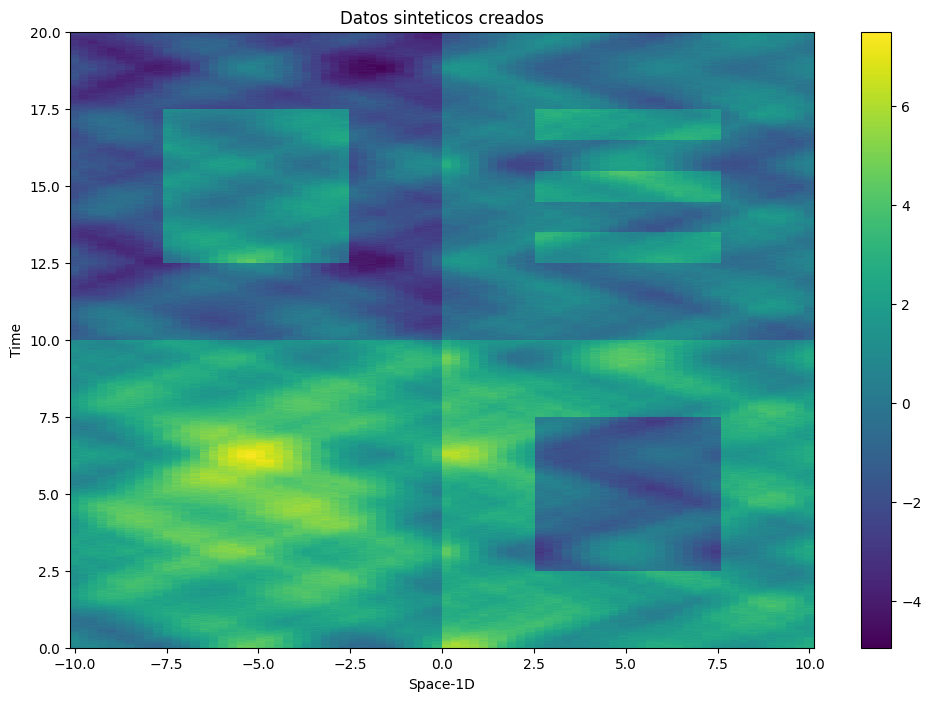

In [4]:
sample_data = create_sample_data()

x = np.linspace(-10, 10, 80)
t = np.linspace(0, 20, 1600)

make_plot(sample_data.T, x=x, y=t,title="Datos sinteticos creados")

# Aplicacion de algoritmo DMD

Primeiro aplicamos o DMD clássico sem o truncamento de classificação svd e depois tentamos reconstruir os dados. Você pode ver claramente que todos os eventos de tempo transitórios estão faltando.

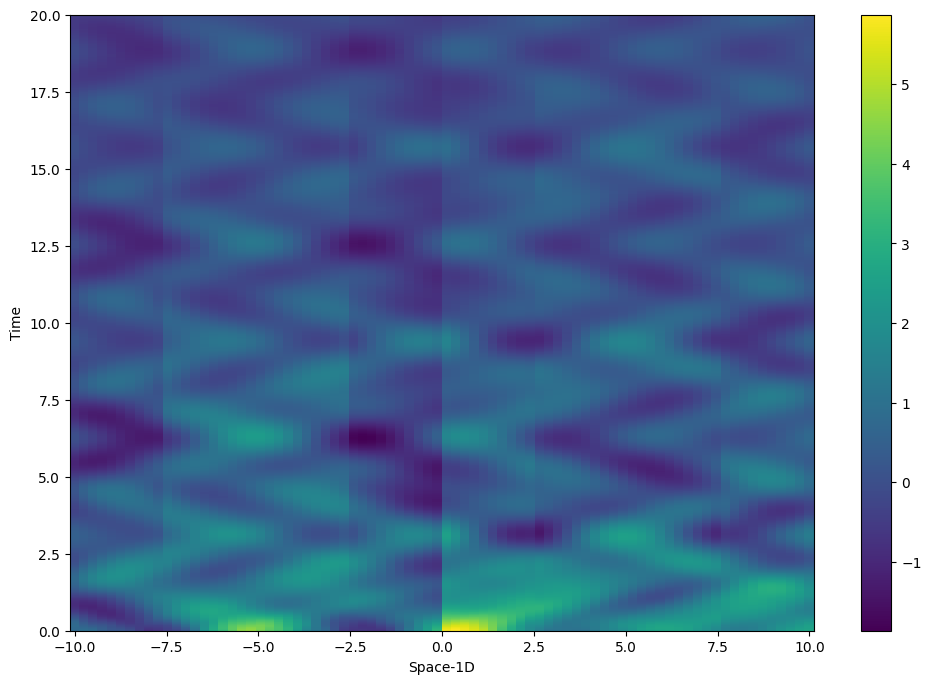

In [5]:
# classDMD(svd_rank=0, tlsq_rank=0, exact=False, opt=False, rescale_mode=None, forward_backward=False, sorted_eigs=False, tikhonov_regularization=None)
first_dmd = DMD(svd_rank=-1)

# Aplica las condiciones con los datos del sistema 
first_dmd.fit(X=sample_data)

# Grafica la reconstruccion del sistema 
make_plot(first_dmd.reconstructed_data.T, x=x, y=t)

Agora fazemos o mesmo, mas usando o mrDMD. O resultado é notável mesmo com o truncamento de classificação svd (experimente alterar os parâmetros de entrada)


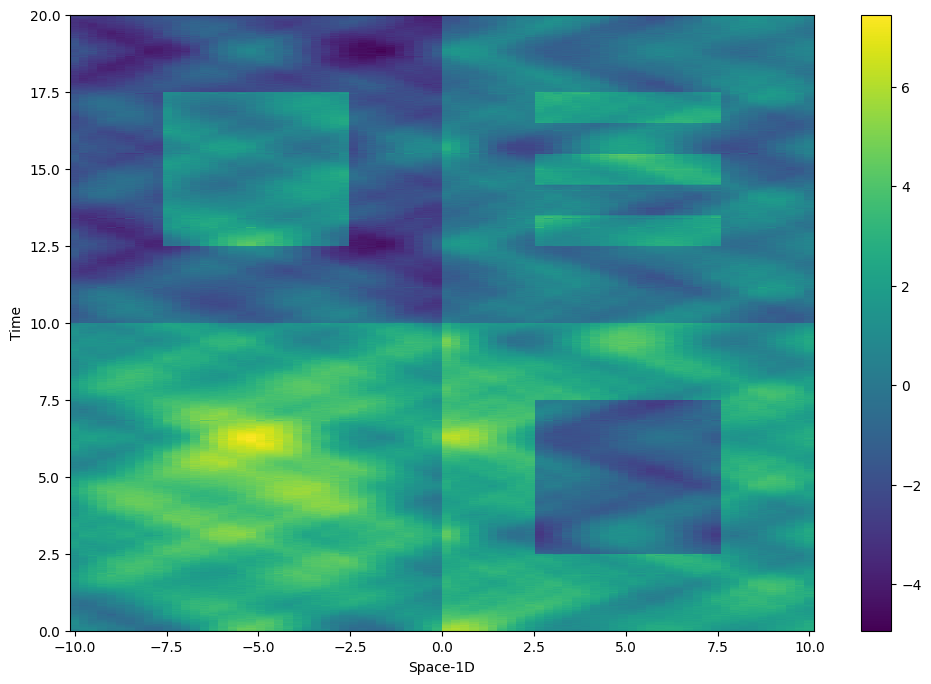

In [6]:
# classDMD(svd_rank=0, tlsq_rank=0, exact=False, opt=False, rescale_mode=None, forward_backward=False, sorted_eigs=False, tikhonov_regularization=None)
sub_dmd = DMD(svd_rank=-1)

# classMrDMD(dmd, max_level=2, max_cycles=1)
dmd = MrDMD(sub_dmd, max_level=7, max_cycles=3)

# Aplicando al conjunto de datos 
dmd.fit(X=sample_data)

# Recosntruyendo los valores obtenidos 
make_plot(dmd.reconstructed_data.T, x=x, y=t)

Ok, incrível, né? Vamos dar uma olhada nos autovalores para entender melhor o mrDMD. Sem truncamento, temos 80 autovalores.

The number of eigenvalues is 1208


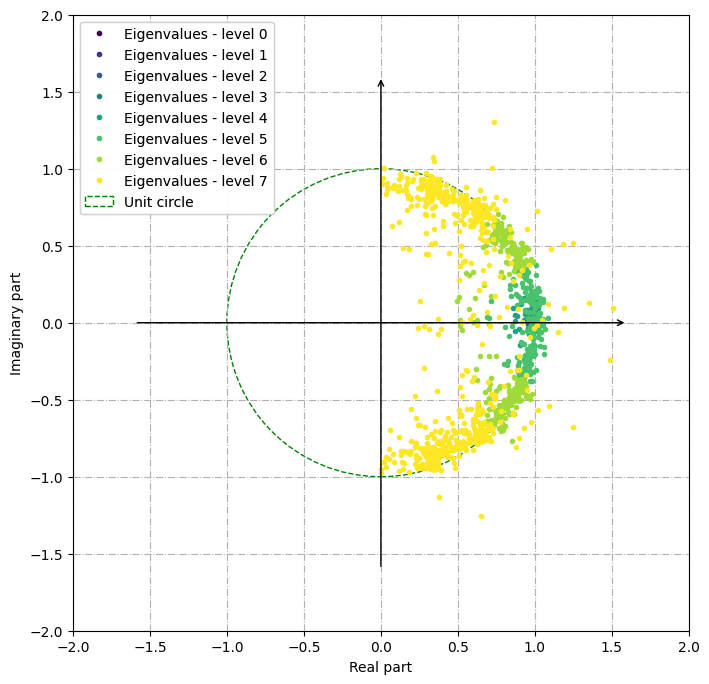

In [7]:
# Devuelve el numero de autovalores 
print("The number of eigenvalues is {}".format(dmd.eigs.shape[0]))

#Grafica los autovalores Obtenidos
plot_eigs_mrdmd(dmd, show_axes=True, show_unit_circle=True, figsize=(8, 8))

Também é possível traçar apenas autovalores específicos, dados o nível e o nó. Se o nó não for fornecido, todos os autovalores desse nível serão plotados.

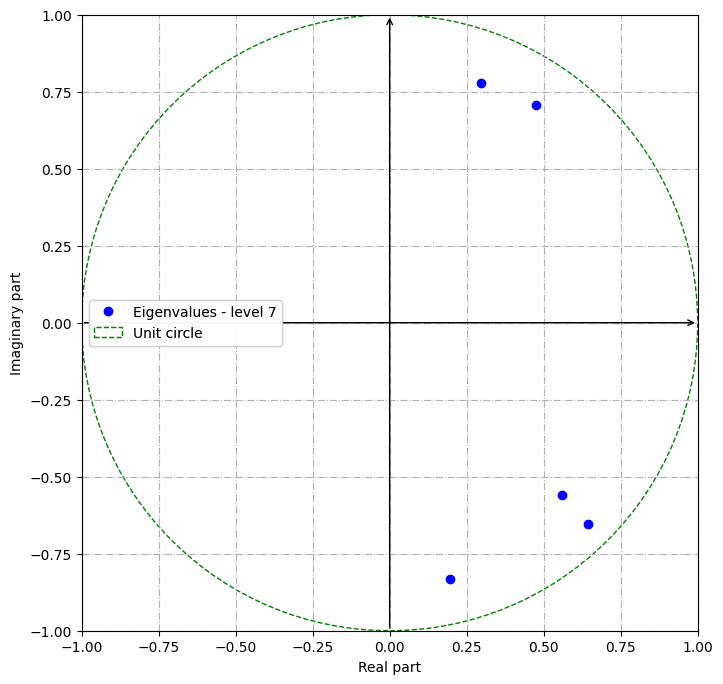

In [8]:
plot_eigs_mrdmd(
    dmd, show_axes=True, show_unit_circle=True, figsize=(8, 8), level=7, node=0
)

A ideia é extrair os modos lentos a cada iteração, onde um modo lento é um modo com frequência relativamente baixa. Isso significa apenas que o modo muda lentamente à medida que o sistema evolui no tempo. Assim, o mrDMD é capaz de capturar diferentes eventos de tempo.

O algoritmo mrDMD geral é o seguinte:

1. Calcule o DMD para os dados disponíveis.
2. Determine os modos rápido e lento.
3. Encontre a melhor aproximação DMD para os dados disponíveis construídos apenas a partir dos modos lentos.
4. Subtraia a aproximação de modo lento dos dados disponíveis.
5. Divida os dados disponíveis pela metade.
6. Repita o procedimento para a primeira metade dos dados (incluindo esta etapa).
7. Repita o procedimento para a segunda metade dos dados (incluindo esta etapa).

Let us have a look at the modes for the first two levels and the corresponding time evolution. At the first level we have two very slow modes, while at the second one there are 5 modes. 

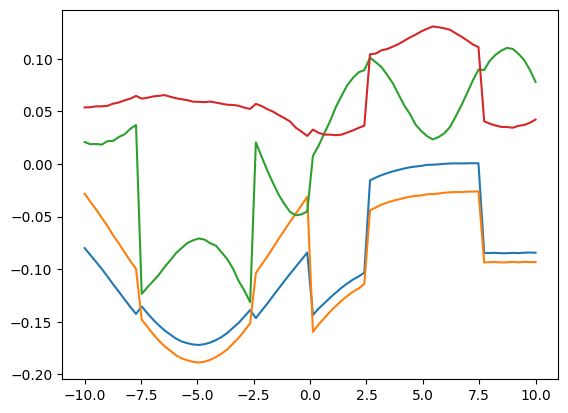

In [9]:
pmodes = dmd.partial_modes(level=0)
fig = plt.plot(x, pmodes.real)

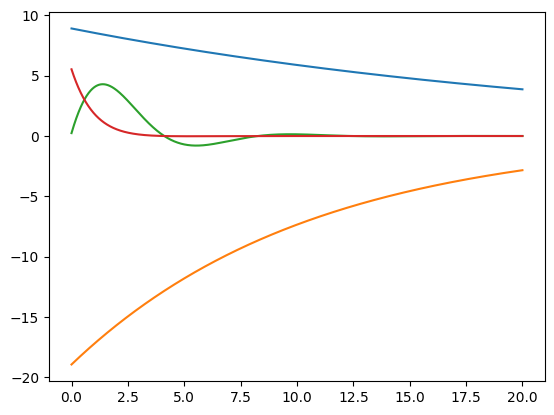

In [10]:
pdyna = dmd.partial_dynamics(level=0)
fig = plt.plot(t, pdyna.real.T)

Observe as descontinuidades na evolução temporal onde os dados foram divididos.

The number of modes in the level number 1 is 8


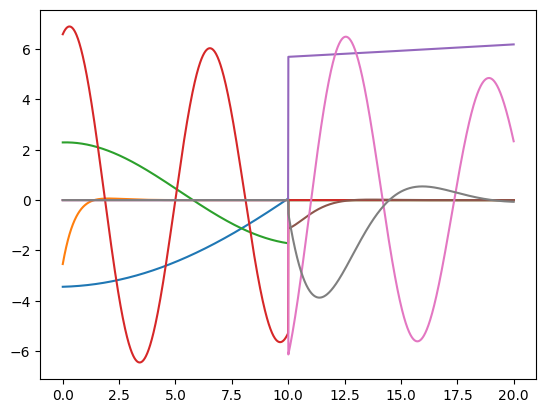

In [11]:
pdyna = dmd.partial_dynamics(level=1)
print("The number of modes in the level number 1 is {}".format(pdyna.shape[0]))
fig = plt.plot(t, pdyna.real.T)

Agora recriamos os dados originais adicionando níveis. Para cada nível, começando pelo primeiro (observe que o índice inicial é 0), construímos uma aproximação dos dados.

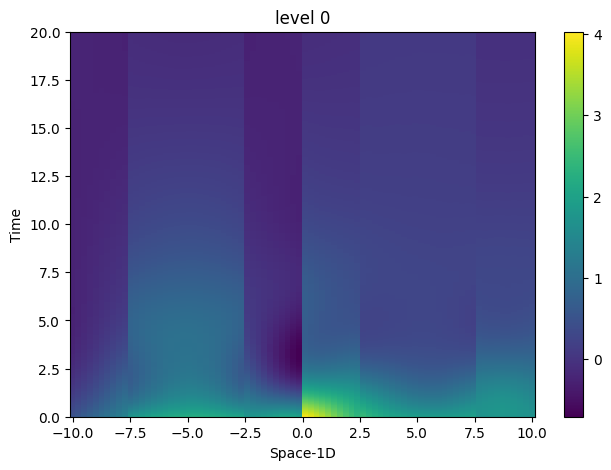

In [12]:
pdata = dmd.partial_reconstructed_data(level=0)
make_plot(pdata.T, x=x, y=t, title="level 0", figsize=(7.5, 5))

Em seguida, adicionamos todos eles sequencialmente, um em cima do outro. É interessante ver como os dados originais foram divididos em recursos de resolução fina e fina.

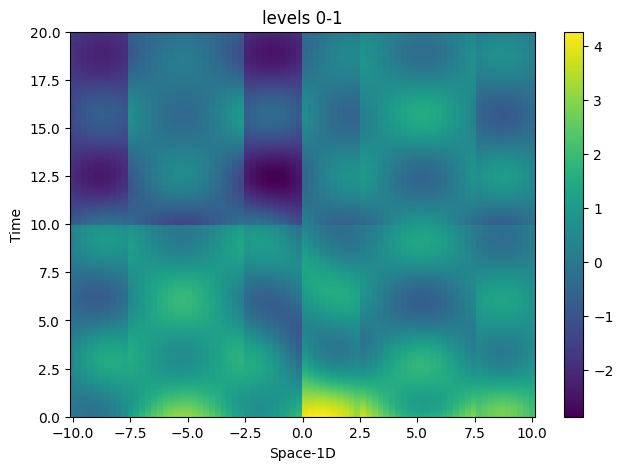

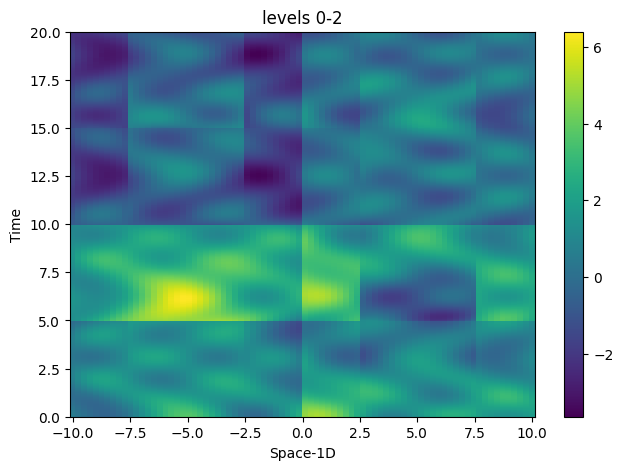

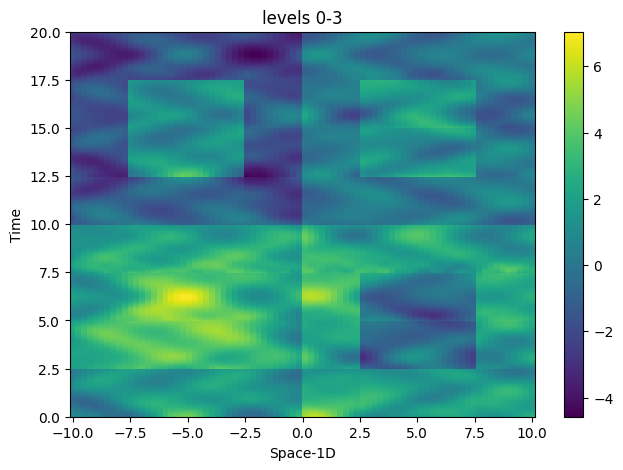

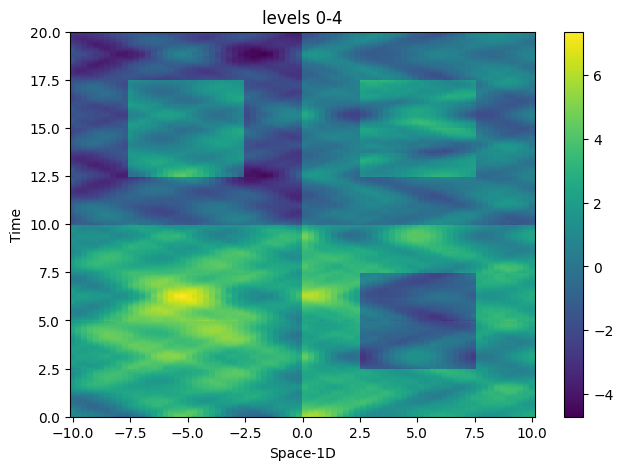

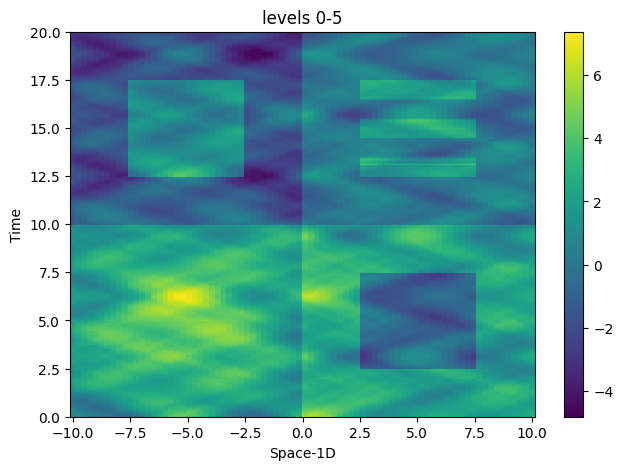

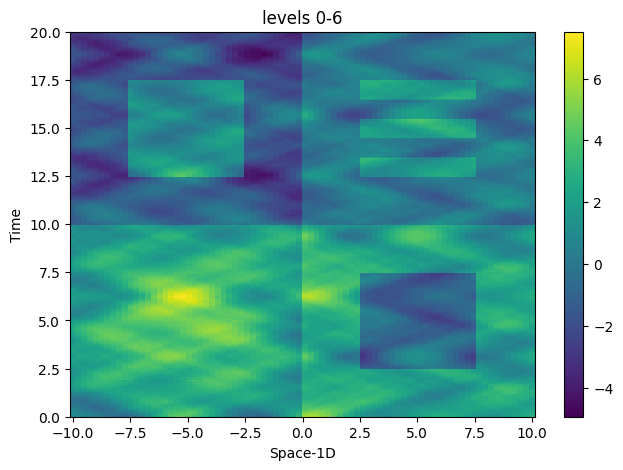

In [13]:
for i in range(1, 7):
    pdata += dmd.partial_reconstructed_data(level=i)
    make_plot(pdata.T, x=x, y=t, title="levels 0-" + str(i), figsize=(7.5, 5))